In [1]:
# import useful libraries and update configs
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import layers as tfl
from sklearn import preprocessing
from pathlib import Path
from PIL import Image 
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
pd.set_option('display.max_rows', 99999)
pd.set_option('max_colwidth', 400)
tf.config.threading.set_inter_op_parallelism_threads(2)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = 'C:/Users/PC/Desktop/4DS-2/Deep Learning Projet/YOGA/TRAIN' #directory with training images
test_dir = 'C:/Users/PC/Desktop/4DS-2/Deep Learning Projet/YOGA/TEST' #directory with testing images

In [3]:
train_generator =  image_dataset_from_directory(directory = train_dir,
                                                    shuffle=True,## Changement des images
                                                    image_size=(224,224),
                                                   validation_split=0.2,
                                    
                                                  subset='training',
                                                   seed=42 # is used to specify the random seed used for shuffling the data )
validation_generator  = image_dataset_from_directory(directory = test_dir,
                                                  shuffle=True,
                                                    image_size=(224,224),
                                                   validation_split=0.2,
                                                   
                                                  subset = 'validation',
                                                        seed=42)


Found 1075 files belonging to 5 classes.
Using 860 files for training.
Found 466 files belonging to 5 classes.
Using 93 files for validation.


In [4]:
#PRINT CLASS NAMES IN TRAINING DATA
class_names = train_generator.class_names
print(class_names)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']


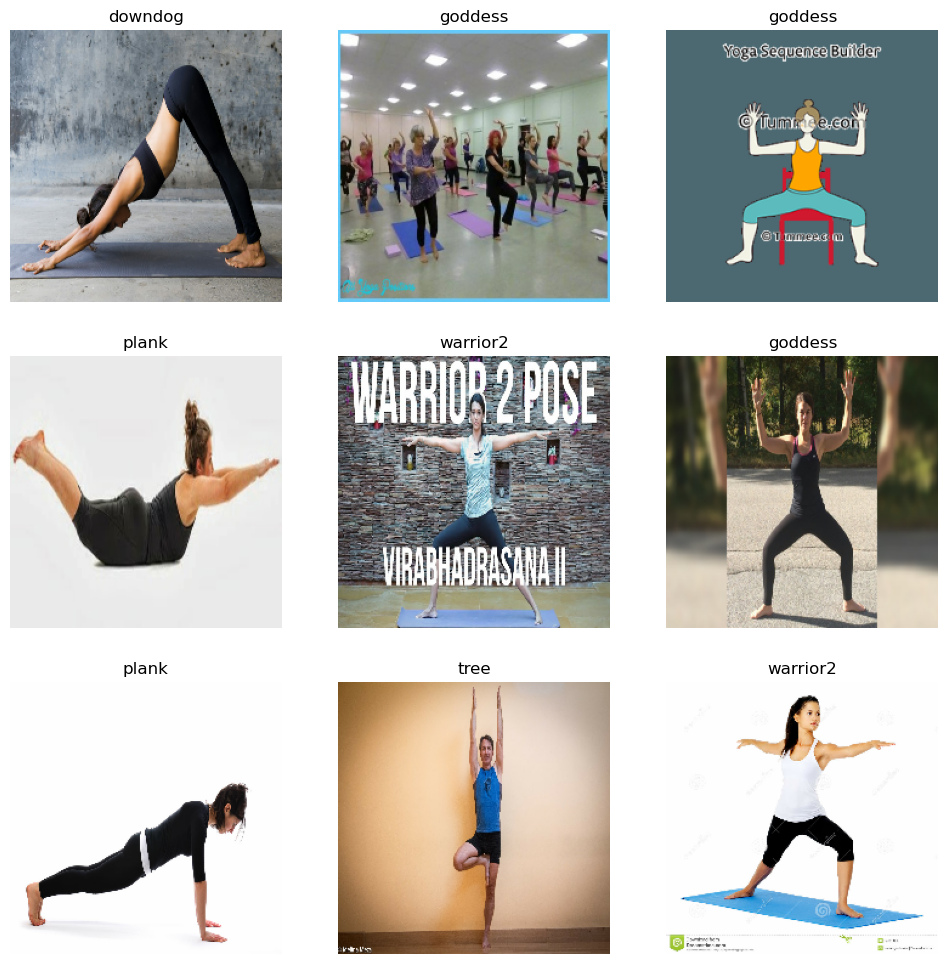

In [5]:
#PLOT FEW TRAINING IMAGES USING MATPLOTLIB
plt.figure(figsize=(12, 12))
for images, labels in train_generator.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Data Pre-processing and Augmentation

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #  tune the parameters of data loading operations
train_generator = train_generator.prefetch(buffer_size=AUTOTUNE) #buffer size optimale on utilise autotune

In [7]:
#DATA AUGMENTATION USING SEQUENTIAL MODEL
# function to randomly flip image and rotate 
def data_augmenter():
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal')) # Flip img horizontally
    data_augmentation.add(RandomRotation(0.2))      # Rotate randomly
    return data_augmentation

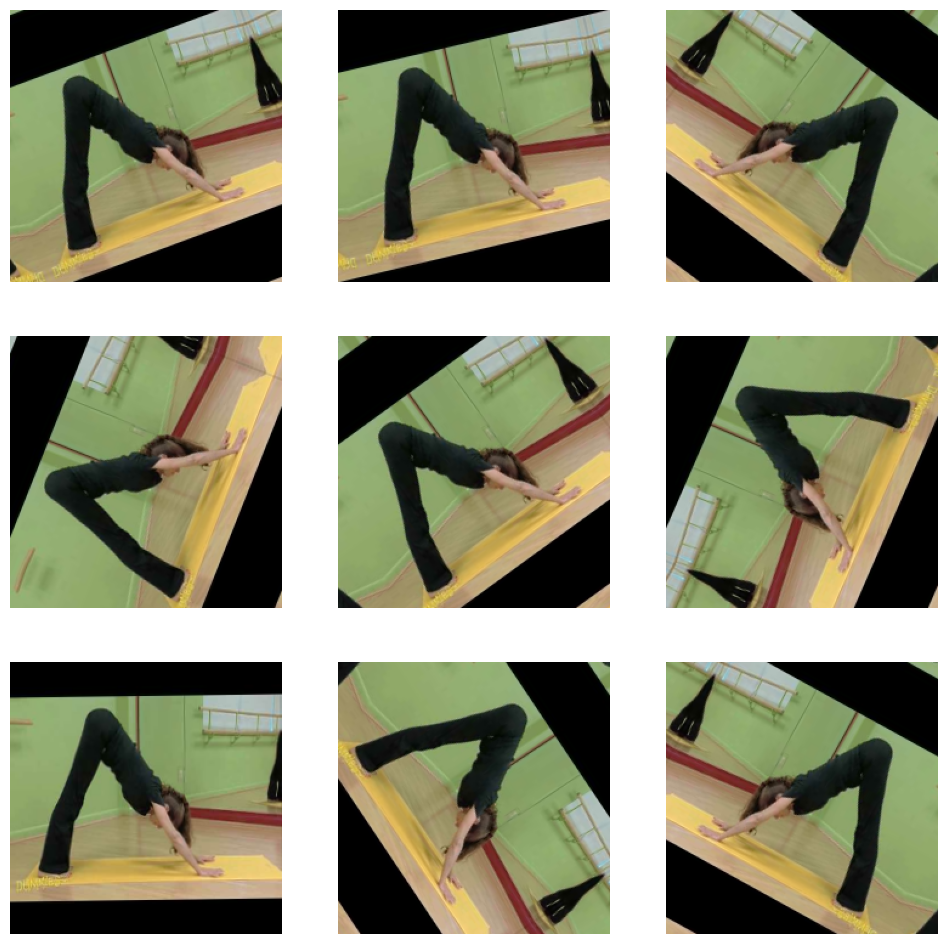

In [8]:
# for illustration, print augmented images of an input image in training data
data_augmentation = data_augmenter()

for image, _ in train_generator.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        
        plt.imshow(augmented_image[0] / 255)
        #The [0] index is used to remove the batch dimension from the tensor before converting it to a NumPy
        
        plt.axis('off')

In [9]:
#NORMALIZE INPUT
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Model Training

In [10]:
# define base model to be the MobileNet for further processing with it
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224) + (3,),
                                                   include_top=False,
                                                   weights='imagenet')

In [11]:
# creates a classification model using MobileNetV2 as the base model, 
#with optional data augmentation applied to the input images.
def model(image_shape=(224,224), data_augmentation=data_augmenter(), base_model=base_model):

    input_shape = image_shape + (3,)
    base_model.trainable = False    # freeze base model by making it non trainable
    inputs = tf.keras.Input(shape=input_shape) # create input layer (Same as imageNetv2 input size)
    x = data_augmentation(inputs) # apply data augmentation to the inputs
    x = preprocess_input(x) # data preprocessing using the same weights the model was trained
    x = base_model(x, training=False) # set training to False
    x = tfl.GlobalAveragePooling2D()(x) # use global avg pooling to summarize the info in each channel
    x = tfl.Dropout(0.2)(x)  # include dropout with probability of 0.2 to avoid overfitting
    outputs = tfl.Dense(units=5, activation='softmax')(x) #use a prediction layer with 'softmax' classification
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [12]:
# COMPILE MODEL
model = model((224,224), data_augmentation, base_model)
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [14]:
#FIT MODEL 
initial_epochs = 10
history = model.fit(train_generator, validation_data=validation_generator, epochs=initial_epochs)

Epoch 1/10
27/27 [==============================] - 33s 938ms/step - loss: 2.0495 - accuracy: 0.4349 - val_loss: 0.8663 - val_accuracy: 0.6882
Epoch 2/10
27/27 [==============================] - 25s 852ms/step - loss: 1.1870 - accuracy: 0.6209 - val_loss: 0.5810 - val_accuracy: 0.7849
Epoch 3/10
27/27 [==============================] - 25s 903ms/step - loss: 0.8549 - accuracy: 0.7081 - val_loss: 0.5097 - val_accuracy: 0.8710
Epoch 4/10
27/27 [==============================] - 25s 873ms/step - loss: 0.7534 - accuracy: 0.7221 - val_loss: 0.6117 - val_accuracy: 0.8172
Epoch 5/10
27/27 [==============================] - 26s 904ms/step - loss: 0.7138 - accuracy: 0.7477 - val_loss: 0.4697 - val_accuracy: 0.8172
Epoch 6/10
27/27 [==============================] - 25s 880ms/step - loss: 0.6322 - accuracy: 0.7814 - val_loss: 0.4261 - val_accuracy: 0.8602
Epoch 7/10
27/27 [==============================] - 26s 917ms/step - loss: 0.5690 - accuracy: 0.8012 - val_loss: 0.3921 - val_accuracy: 0.8817

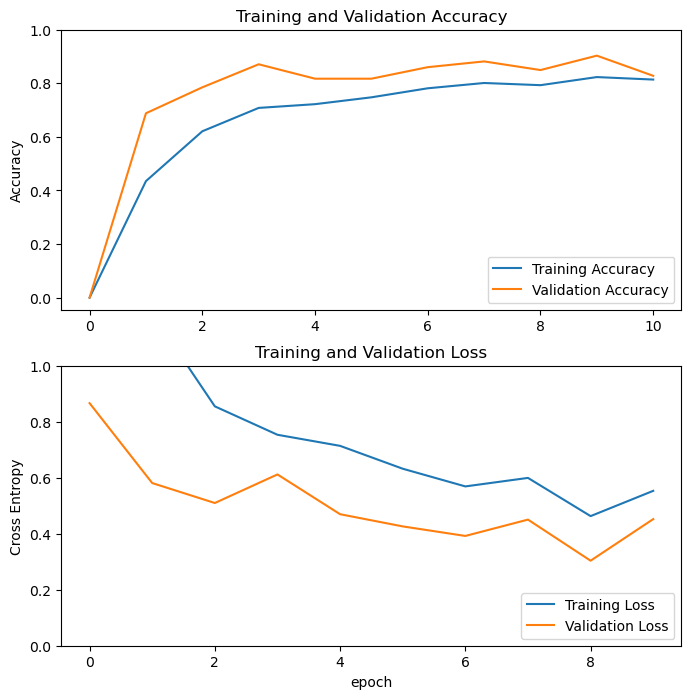

In [15]:
#PLOT TRAINING AND VALIDATION ACCURACY
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

3/3 [==============================] - 3s 647ms/step - loss: 0.4522 - accuracy: 0.8280
final train accuracy = 86.51 , validation accuracy = 82.80


In [17]:
model.save('YogaNet_model_mobile1.h5')

In [18]:
from keras.models import load_model
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
import numpy as np
# Load pre-trained MobileNet model
model = load_model('YogaNet_model_mobile1.h5')

# Load image from file
image_path = 'C:/Users/PC/Desktop/4DS-2/Deep Learning Projet/YOGA/TEST/warrior2/00000000.jpg'
img = Image.open(image_path).resize((224, 224))
# Convert image to array and expand dimensions
x = np.array(img)
x = np.expand_dims(x, axis=0)

# Preprocess image data
img_data = preprocess_input(x)

# Make predictions using the loaded model
classes = model.predict(img_data)
# Set threshold for binary classification
threshold = 0.5

# Convert probabilities to binary values (0 or 1)
binary_classes = (classes > threshold).astype(int)

print(binary_classes)

1/1 [==============================] - 2s 2s/step
[[1 0 0 0 0]]


## FINE-TUNED MODEL

In [16]:
# unfreezing some of its layers and training them along with the additional layers added on top
#Fine-tuning can help to achieve better performance compared to training a model from scratch, 
#especially when the new dataset is small 
base_model = model.layers[4] #Retrieves the 5th layer (index 4) from the model 
base_model.trainable = True #unfreeze the base model 
fine_tune_at = 120 # Fine-tune from this layer onwards

for layer in base_model.layers[:fine_tune_at]: # Freeze all the layers before the `fine_tune_at` layer
    layer.trainable = True
loss_function=tf.keras.losses.SparseCategoricalCrossentropy() # Define a Sparse Categorical Croos Entropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01*base_learning_rate#  used in fine-tuning) # Define an Adam optimizer with a learning rate of 0.01 * base_learning_rate
metrics=['accuracy'] # Use accuracy as evaluation metric
model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [17]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 10/20
27/27 [==============================] - 84s 2s/step - loss: 0.9624 - accuracy: 0.6767 - val_loss: 0.3558 - val_accuracy: 0.8817
Epoch 11/20
27/27 [==============================] - 64s 2s/step - loss: 0.5290 - accuracy: 0.8093 - val_loss: 0.2609 - val_accuracy: 0.9140
Epoch 12/20
27/27 [==============================] - 74s 3s/step - loss: 0.3728 - accuracy: 0.8674 - val_loss: 0.2137 - val_accuracy: 0.9355
Epoch 13/20
27/27 [==============================] - 72s 3s/step - loss: 0.3146 - accuracy: 0.8942 - val_loss: 0.2001 - val_accuracy: 0.9570
Epoch 14/20
27/27 [==============================] - 78s 3s/step - loss: 0.2668 - accuracy: 0.9198 - val_loss: 0.1718 - val_accuracy: 0.9570
Epoch 15/20
27/27 [==============================] - 78s 3s/step - loss: 0.2282 - accuracy: 0.9221 - val_loss: 0.1718 - val_accuracy: 0.9462
Epoch 16/20
27/27 [==============================] - 75s 3s/step - loss: 0.2141 - accuracy: 0.9221 - val_loss: 0.1509 - val_accuracy: 0.9462
Epoch 17/20
2

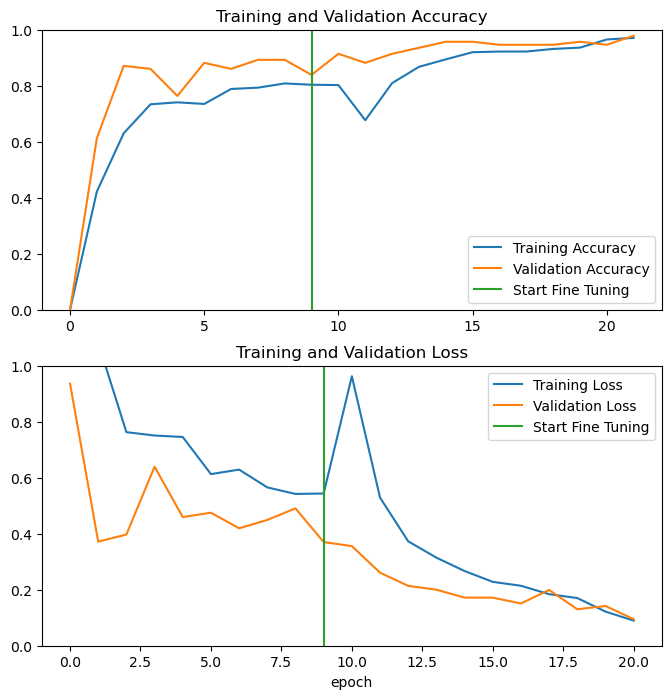

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
model.save('YogaNet_model_mobile.h5')


In [29]:
from keras.models import load_model
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
import numpy as np
# Load pre-trained MobileNet model
model = load_model('YogaNet_model_mobile.h5')

# Load image from file
image_path = 'C:/Users/PC/Desktop/4DS-2/Deep Learning Projet/YOGA/TEST/downdog/00000000.jpg'
img = Image.open(image_path).resize((224, 224))
# Convert image to array and expand dimensions
x = np.array(img)
x = np.expand_dims(x, axis=0)

# Preprocess image data
img_data = preprocess_input(x)

# Make predictions using the loaded model
classes = model.predict(img_data)
# Set threshold for binary classification
threshold = 0.5

# Convert probabilities to binary values (0 or 1)
binary_classes = (classes > threshold).astype(int)

print(binary_classes)


1/1 [==============================] - 1s 778ms/step
[[1 0 0 0 0]]
